# Music Genre Recognition Report
### Group 8: Ian Lowe, Christian Martinez, Martin Ronquillo, and Sabrina Ferras

---



## Introduction
Many things need to be categorized, but it is challenging to do so without textual or numerical data. One particularly interesting problem is the categorization of audio data. Using our dataset, which contains textual lyric data as well as descriptive features that were quantified by Spotify, ***we aim to classify the genre of a song based on features such as loudness, danceability, mood, and lyrical content.*** To accomplish this, we’ll be utilizing many of sci-kit learn’s classification estimators including KNN, Decision Trees, and Random Forest to attempt to determine the genre of any given song based on lyrical data.


## Selection of Data
### Dataset
The dataset from Mendeley is a .csv which contains over 28,000 entries of songs. It also contains music metadata (e.g. sadness, danceability, loudness) and the songs are from 1950 to 2019. The data was collected using the Echo Nest API and the spotipy Python package. The lyrics were obtained using the Lyrics Genius API, based on the song title and artist name.
### Characteristics of Data
The main attributes that would be a good focus of interest for this project are Genre, Lyrics, and Artist. There are a total of 7 different genres in the dataset: rock, reggae, jazz, blues, hip hop, country, and pop. 
There is an associated paper about this dataset titled “Temporal Analysis and Visualisation of Music.” This paper goes in depth about characteristics of the data and its calculations. For example, there is an attribute “Acousticness” which is defined in the paper as having the “Presence of acoustic instruments.”
#### Dataset: https://data.mendeley.com/datasets/3t9vbwxgr5/3
#### Associated Analysis Paper: https://sol.sbc.org.br/index.php/eniac/article/view/12155/12020

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,6
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("https://raw.githubusercontent.com/ChrisMart21/383-Group-Project-ML-Music/main/tcc_ceds_music.csv", index_col=0)

## Target

In [ ]:
# Our goal is to predict the music 'genre'
# 7 total Genres
target = ['genre']
df['genre'].value_counts()

pop        7042
country    5445
blues      4604
rock       4034
jazz       3845
reggae     2498
hip hop     904
Name: genre, dtype: int64

## Predictors  
This data contains a total of 22 numeric predictors for each song/genre entry. These predictors can be broadly split into two main categories, '***Song Topic Scoring***' and '***Musical Features Scoring***' each ranging from 0 to 1. We will leverage this detailed data to generate 3 different models consisting of predictors 'A', 'B', 'A+B'

In [ ]:
#predictor 'A'
predictor_topics = ['dating', 'violence', 'world/life', 'night/time', 
                    'shake the audience', 'family/gospel', 'romantic',
                    'communication', 'obscene', 'music', 'movement/places',
                    'light/visual perceptions', 'family/spiritual','like/girls',
                    'sadness', 'feelings']
#predictor 'B'
predictor_music_features = ['danceability', 'loudness', 'acousticness',
                            'instrumentalness', 'valence', 'energy']
#both 'A + B'
predictor_all = predictor_topics + predictor_music_features

## Preliminary work - Data Preparations

In [ ]:
#Removing data from before or from 2017 due to they style of music changing a lot since then, as well as removing the genres 'reggae' and 'hip hop'
df = df[(df['release_date'] >= 2017) & ((df['genre'] != 'reggae') & (df['genre'] != 'hip hop'))]

# One Hot Encoding
# encoder = OneHotEncoder(handle_unknown='ignore')
# target_one_hot = pd.DataFrame(encoder.fit_transform(df[target]).toarray())
# target_one_hot.columns = df['genre'].unique()

#Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target_le = pd.DataFrame(le.fit_transform(np.ravel(df[target]))) #using .ravel() to remove warning about shape


# topic data prep
topic_features = df[predictor_topics]
music_features = df[predictor_music_features]
all_features = df[predictor_all]


## Preliminary work - Data Exploration and Visualization

### Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278 entries, 19341 to 80960
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   artist_name               1278 non-null   object 
 1   track_name                1278 non-null   object 
 2   release_date              1278 non-null   int64  
 3   genre                     1278 non-null   object 
 4   lyrics                    1278 non-null   object 
 5   len                       1278 non-null   int64  
 6   dating                    1278 non-null   float64
 7   violence                  1278 non-null   float64
 8   world/life                1278 non-null   float64
 9   night/time                1278 non-null   float64
 10  shake the audience        1278 non-null   float64
 11  family/gospel             1278 non-null   float64
 12  romantic                  1278 non-null   float64
 13  communication             1278 non-null   float64
 14  obs

In [ ]:
df.describe()

,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,...,like/girls,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,age
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,...,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000
mean,2017.933490,86.089202,0.018776,0.142754,0.105924,0.054130,0.029147,0.014956,0.024671,0.071438,...,0.030671,0.117072,0.028077,0.558297,0.734633,0.229783,0.082851,0.446633,0.642800,0.029522
std,0.787205,45.783015,0.043383,0.189347,0.162829,0.103597,0.052656,0.038696,0.065287,0.104074,...,0.060412,0.170699,0.060583,0.164673,0.076089,0.274349,0.221295,0.220720,0.203089,0.011246
min,2017.000000,1.000000,0.000315,0.000315,0.000301,0.000346,0.000342,0.000301,0.000315,0.000346,...,0.000301,0.000315,0.000342,0.097801,0.124529,0.000011,0.000000,0.015973,0.050321,0.014286
25%,2017.000000,49.000000,0.000752,0.000927,0.000835,0.000822,0.000993,0.000731,0.000711,0.000907,...,0.000774,0.000907,0.000810,0.456298,0.704311,0.016515,0.000000,0.277617,0.505740,0.014286
50%,2018.000000,80.000000,0.001350,0.036336,0.003010,0.001880,0.002149,0.001316,0.001350,0.002506,...,0.001422,0.003509,0.001645,0.561356,0.749122,0.105421,0.000031,0.430647,0.674665,0.028571
75%,2019.000000,117.000000,0.004785,0.305575,0.148849,0.064782,0.036330,0.005702,0.020158,0.121085,...,0.031385,0.187153,0.033306,0.673995,0.784235,0.361445,0.005709,0.601711,0.803297,0.042857
max,2019.000000,199.000000,0.362900,0.927126,0.766905,0.735489,0.402632,0.502873,0.864662,0.599669,...,0.386218,0.852977,0.526316,0.978339,0.885624,0.995984,0.993927,0.975268,0.985986,0.042857


In [ ]:
df.corr()

,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,...,like/girls,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,age
release_date,1.000000,0.000599,-0.021424,-0.008955,-0.008615,0.021668,0.040296,0.030347,-0.044471,-0.033837,...,0.004294,-0.040235,-0.031198,0.018391,0.051561,-0.072207,-0.008167,0.021728,0.071666,-1.000000
len,0.000599,1.000000,0.041516,-0.136853,-0.174779,-0.060549,0.224751,0.009925,-0.091255,-0.010120,...,0.097607,-0.131278,-0.033126,0.392302,0.158529,-0.092432,-0.140661,0.150815,0.067195,-0.000599
dating,-0.021424,0.041516,1.000000,-0.096495,-0.064834,0.016264,-0.002099,-0.005780,0.025130,-0.035637,...,0.005282,0.049147,-0.004244,0.014236,0.012287,-0.014306,-0.017386,0.058645,-0.012866,0.021424
violence,-0.008955,-0.136853,-0.096495,1.000000,-0.206975,-0.118914,-0.098632,-0.018016,-0.072353,-0.112843,...,-0.098260,-0.219773,-0.079927,-0.175856,-0.002213,-0.095886,0.133918,-0.079593,0.117018,0.008955
world/life,-0.008615,-0.174779,-0.064834,-0.206975,1.000000,-0.116900,-0.052357,-0.013319,-0.041029,-0.097527,...,-0.044062,-0.159474,-0.031918,-0.126299,-0.071862,0.070819,-0.023776,-0.074164,-0.069936,0.008615
night/time,0.021668,-0.060549,0.016264,-0.118914,-0.116900,1.000000,-0.058860,-0.004434,-0.007233,-0.026458,...,0.007468,-0.101217,-0.003229,-0.006735,0.017789,-0.037953,0.012624,0.074184,0.071475,-0.021668
shake the audience,0.040296,0.224751,-0.002099,-0.098632,-0.052357,-0.058860,1.000000,-0.027790,-0.046684,-0.044599,...,-0.023804,-0.067673,-0.047537,0.092519,0.064995,-0.055265,-0.072925,-0.024530,0.038864,-0.040296
family/gospel,0.030347,0.009925,-0.005780,-0.018016,-0.013319,-0.004434,-0.027790,1.000000,0.045260,-0.089512,...,-0.028143,-0.050096,-0.008717,0.001028,0.008984,-0.013176,0.025655,0.033440,0.013262,-0.030347
romantic,-0.044471,-0.091255,0.025130,-0.072353,-0.041029,-0.007233,-0.046684,0.045260,1.000000,-0.056290,...,-0.014168,-0.039136,-0.022631,-0.035025,-0.081253,0.055034,0.007418,-0.034668,-0.064184,0.044471
communication,-0.033837,-0.010120,-0.035637,-0.112843,-0.097527,-0.026458,-0.044599,-0.089512,-0.056290,1.000000,...,-0.081824,0.035958,-0.025299,0.032563,-0.028831,0.059650,-0.057422,-0.034089,-0.074035,0.033837


### Visualization

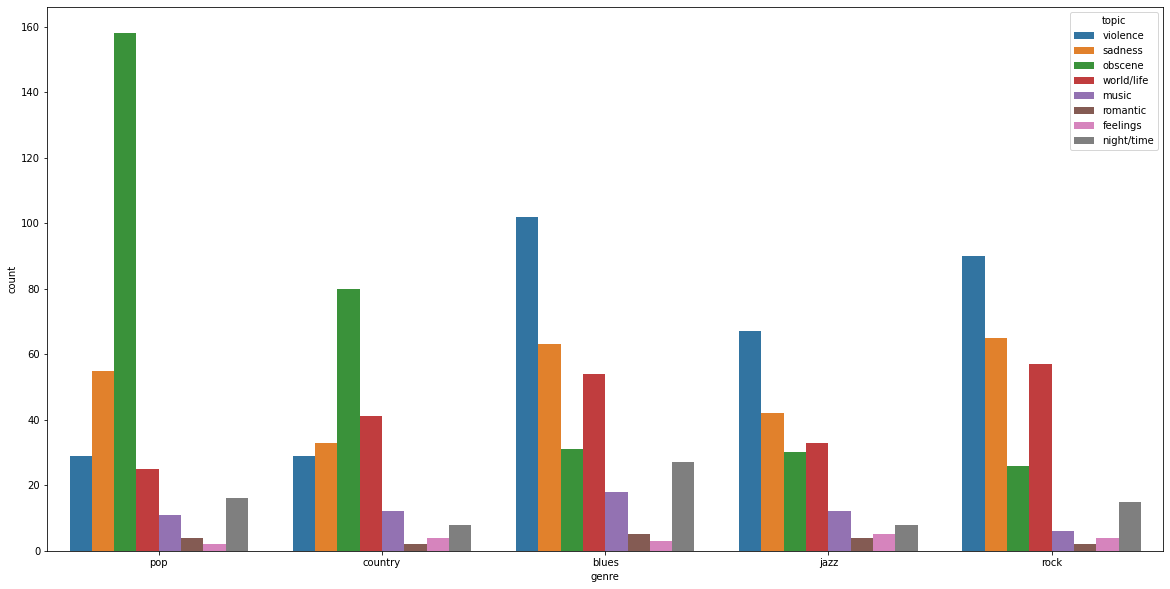

In [ ]:
# some exploration and visualization
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(x='genre', data=df, hue='topic');

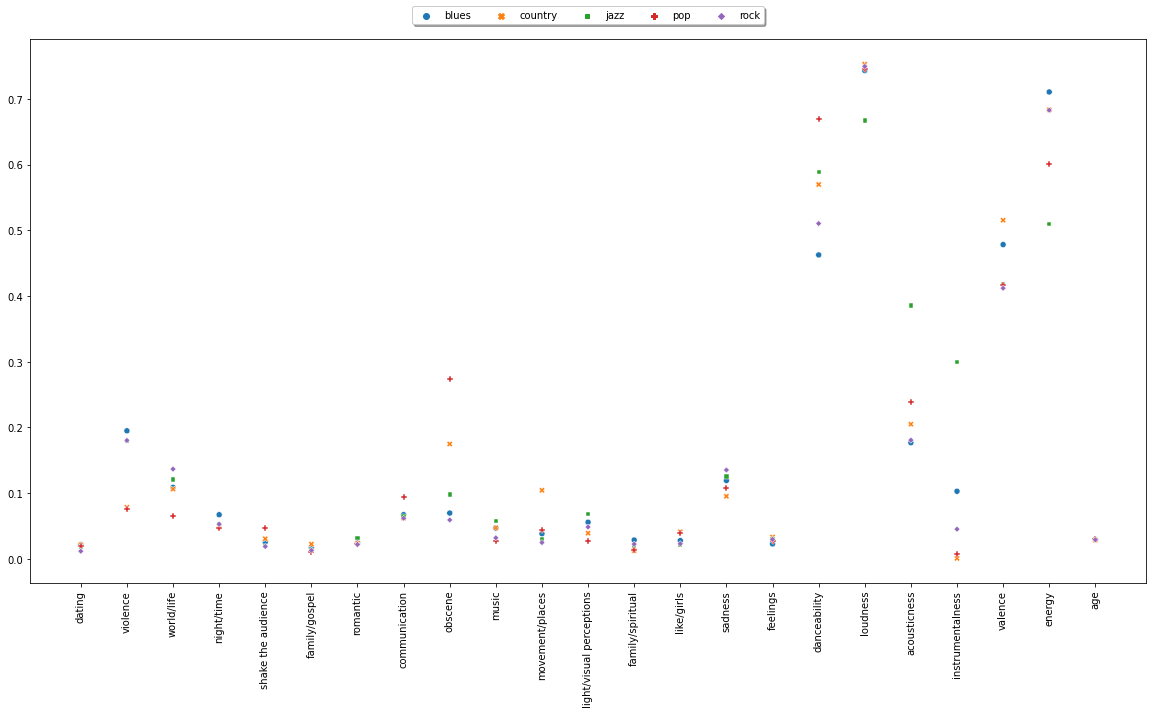

In [ ]:
data = df.groupby('genre').mean(numeric_only=True).drop(['release_date','len'], axis=1)
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=data.T)
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(.5, 1.07),
          ncol=7, fancybox=True, shadow=True);

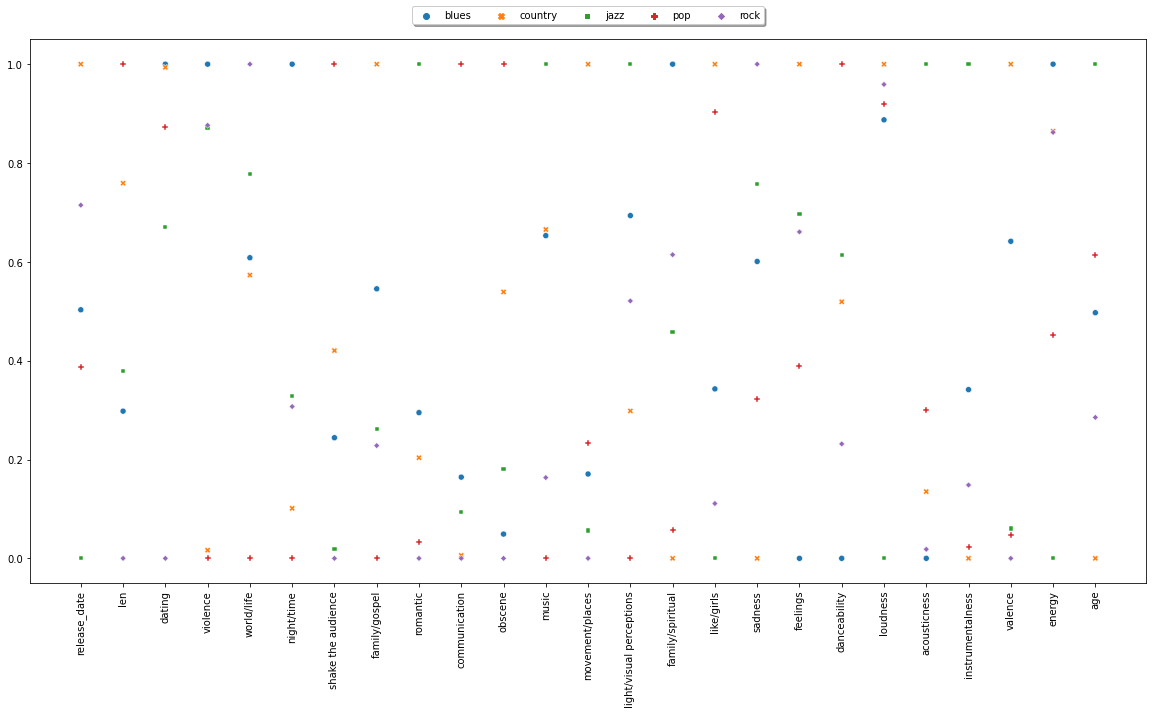

In [ ]:
#min max scaling data
data = df.groupby('genre').mean(numeric_only=True)
data = (data - data.min())/(data.max()-data.min())
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=data.T)
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(.5, 1.07),
          ncol=7, fancybox=True, shadow=True);

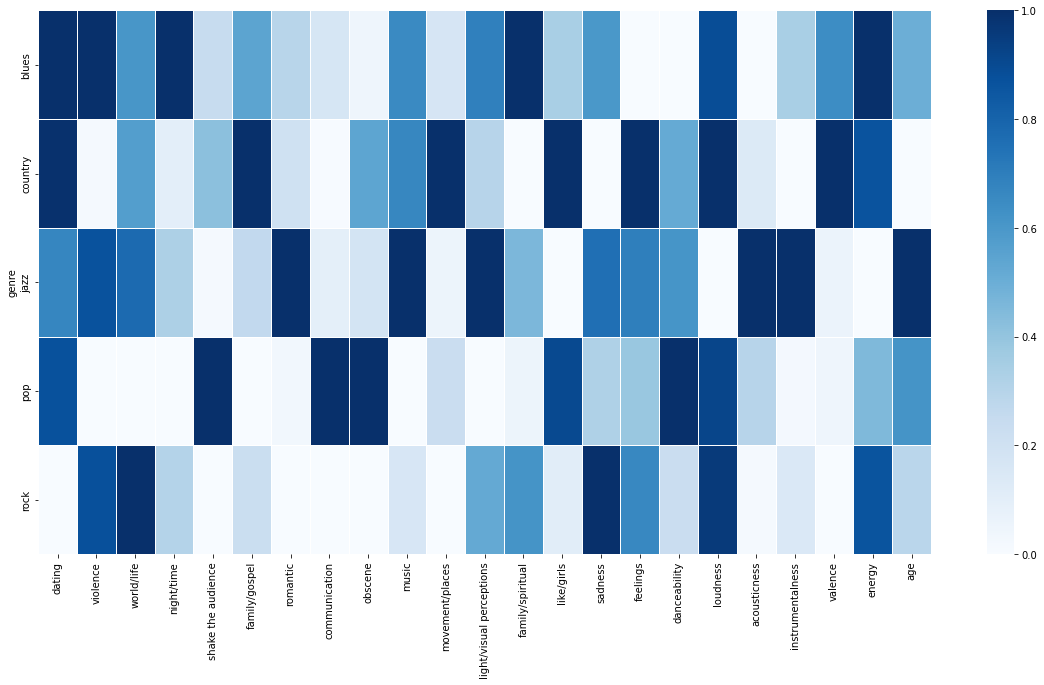

In [ ]:
data = df.groupby('genre').mean(numeric_only=True).drop(['release_date','len'], axis=1)
data = (data - data.min())/(data.max()-data.min())
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data, linewidths=.5, cmap='Blues');

## Preliminary work - Machine Learning

### Train Test Split and Standard Scaler

In [ ]:
# TOPIC_FEATURES
X_topic_train_raw, X_topic_test_raw, y_topic_train, y_topic_test = train_test_split(
    topic_features, target_le, test_size=.30, random_state=0
)

#use standard scaler for topic
scaler_topic = StandardScaler()
X_topic_train = scaler_topic.fit_transform(X_topic_train_raw)
X_topic_test = scaler_topic.transform(X_topic_test_raw)

# MUSIC_FEATURES
X_mFeatures_train_raw, X_mFeatures_test_raw, y_mFeatures_train, y_mFeatures_test = train_test_split(
    music_features, target_le, test_size=.30, random_state=0
)


#use standard scaler
scaler_features = StandardScaler()
X_mfeatures_train = scaler_features.fit_transform(X_mFeatures_train_raw)
X_mfeatures_test = scaler_features.transform(X_mFeatures_test_raw)


# ALL_FEATURES
X_allFeatures_train_raw, X_allFeatures_test_raw, y_allFeatures_train, y_allFeatures_test = train_test_split(
    all_features, target_le, test_size=.30, random_state=0
)


#use standard scaler
scaler_allFeatures = StandardScaler()
X_allFeatures_train = scaler_features.fit_transform(X_allFeatures_train_raw)
X_allFeatures_test = scaler_features.transform(X_allFeatures_test_raw)


## Methods - Machine Learning
We implemented three machine learning algorithms to predict the genre of a song based off given lyrical characteristics. The machine learning algorithms we used below are KNN, Decsion Tree, and Random Forest.
### KNN Classifier

#### **Topic Features**

In [ ]:
# TOPIC_FEATURES
from sklearn.metrics import accuracy_score 
knn = KNeighborsClassifier()
knn.fit(X_topic_train, np.ravel(y_topic_train))
predictions = knn.predict(X_topic_test)
print(accuracy_score(y_topic_test, predictions))

0.3098958333333333


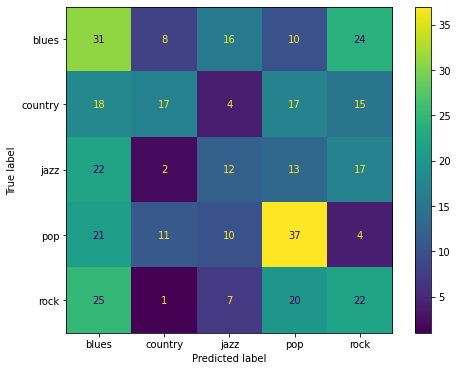

0    303
3    300
4    265
1    209
2    201
dtype: int64
genre  
blues      303
pop        300
rock       265
country    209
jazz       201
dtype: int64


In [ ]:
cm = confusion_matrix(y_topic_test, predictions, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['blues', 'country', 'jazz', 'pop', 'rock'])
disp.plot()
plt.show()

# sanity check that labels correspond to the right encoded values
print(target_le.value_counts())
print(df[target].value_counts())

#### **Music Features**

In [ ]:
# MUSIC_FEATURES
knn = KNeighborsClassifier()
knn.fit(X_mfeatures_train, np.ravel(y_mFeatures_train))
predictions = knn.predict(X_mfeatures_test)
print(accuracy_score(y_mFeatures_test, predictions))



0.4010416666666667


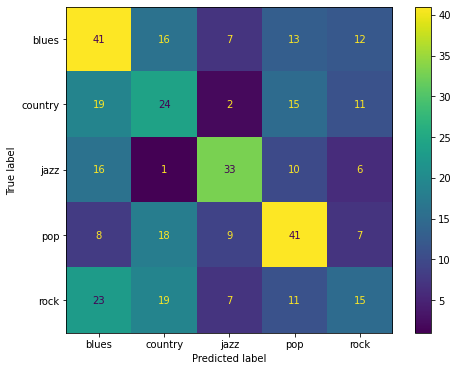

0    303
3    300
4    265
1    209
2    201
dtype: int64
genre  
blues      303
pop        300
rock       265
country    209
jazz       201
dtype: int64


In [ ]:
cm = confusion_matrix(y_mFeatures_test, predictions, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['blues', 'country', 'jazz', 'pop', 'rock'])
disp.plot()
plt.show()

# sanity check that labels correspond to the right encoded values
print(target_le.value_counts())
print(df[target].value_counts())

### Decision Tree

#### **Topic Features**

0.3567708333333333


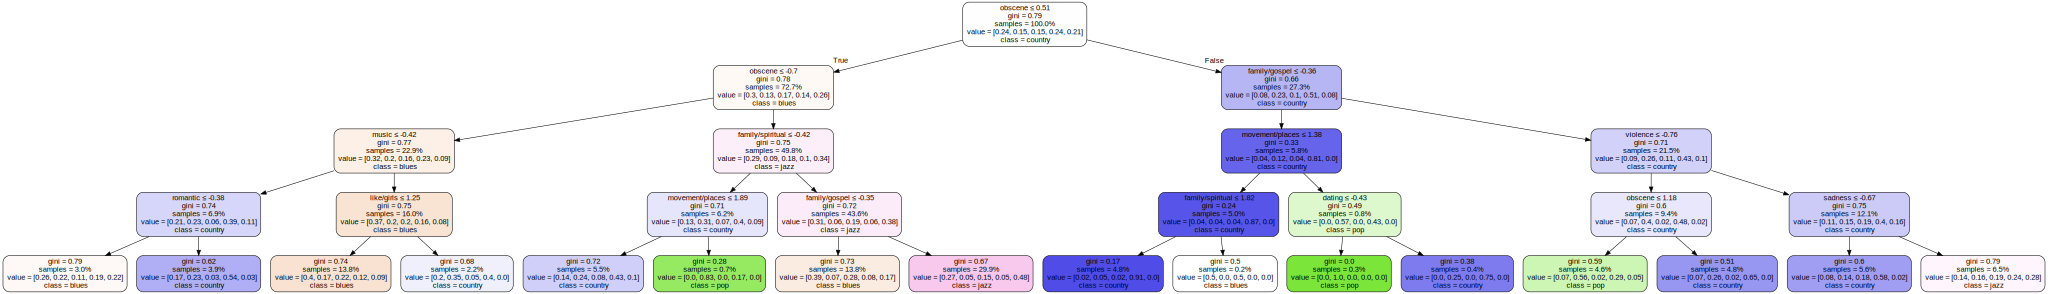

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
import graphviz 

clf = DecisionTreeClassifier(random_state=42, max_depth=4, max_features=0.4)
clf.fit(X_topic_train, np.ravel(y_topic_train))

predictions = clf.predict(X_topic_test)
print(accuracy_score(y_topic_test, predictions))
target_names = df['genre'].value_counts().index.values
dot_data = export_graphviz(clf, precision=2,
                     feature_names=predictor_topics,  
                     proportion=True,
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)

# plot it
graph = graphviz.Source(dot_data)  
graph

#### **Music Features**

0.4739583333333333


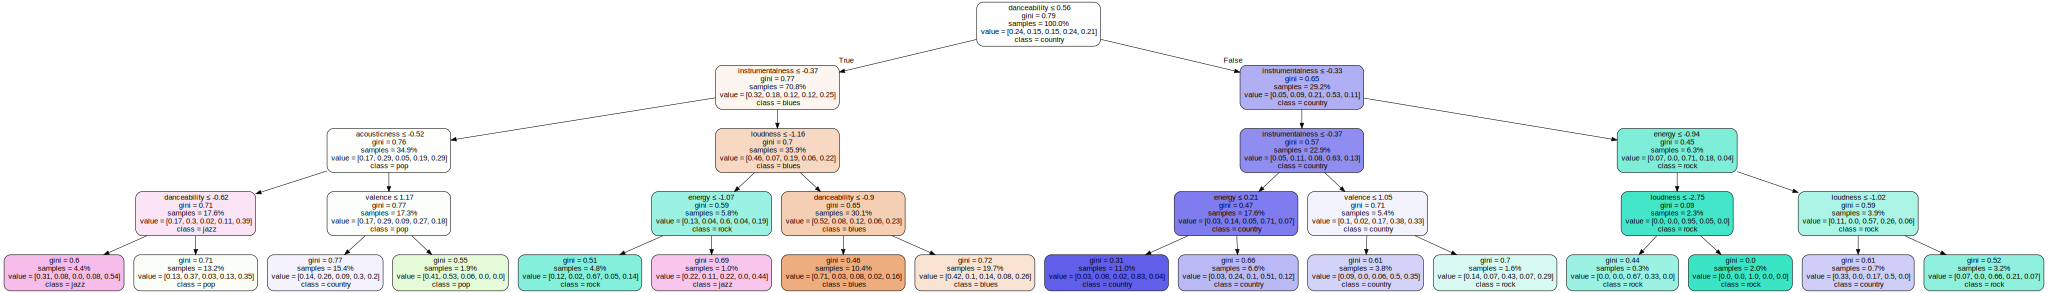

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
import graphviz 
clf = DecisionTreeClassifier(random_state=42, max_depth=4)
clf.fit(X_mfeatures_train, np.ravel(y_mFeatures_train))

predictions = clf.predict(X_mfeatures_test)
print(accuracy_score(y_mFeatures_test, predictions))
target_names = df['genre'].value_counts().index.values
dot_data = export_graphviz(clf, precision=2,
                     feature_names=predictor_music_features,  
                     proportion=True,
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)

# plot it
graph = graphviz.Source(dot_data)  
graph

### Random Forest

#### **Topic Features**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

forest = RandomForestClassifier(criterion='entropy', random_state=42, max_depth=6, max_features=0.6) #used same params as decision tree
forest.fit(X_topic_train, np.ravel(y_topic_train))
predictions = forest.predict(X_topic_test)
print("Accuracy:",metrics.accuracy_score(y_topic_test, predictions))

Accuracy: 0.4088541666666667


#### **Music Features**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

forest = RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=200,
                       n_jobs=-1, random_state=42) #best params found using GridSearchCV
forest.fit(X_mfeatures_train, np.ravel(y_mFeatures_train))
predictions = forest.predict(X_mfeatures_test)
print("Accuracy:",metrics.accuracy_score(y_mFeatures_test, predictions))

Accuracy: 0.53125


#### **All Features**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

forest = RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=30,
                       n_jobs=-1, random_state=42) #best params found using GridSearchCV
forest.fit(X_allFeatures_train, np.ravel(y_allFeatures_train))
predictions = forest.predict(X_allFeatures_test)
print("Accuracy:",metrics.accuracy_score(y_allFeatures_test, predictions))

Accuracy: 0.5520833333333334


## Results
**What answer was found to the research question; what did the study find? Was the tested hypothesis true? Any visualizations?**

In our quest to classify the genre of songs in our dataset we ran into some issues in terms of representing our target variable. Initially used sklearn's one-hot encoder to represent our target variable, but ultimately this encoder was causing inaccuracies with the machine learning algorithms. Using one-hot encoder we were getting around an 8% accuracy with the Random Forest machine learning algorithm. By switching to sklearn's Label Encoder we were able to get the accuracy up to 55% using sklean's for the same algorithm. This showed us the importance of how we represent out target variable and the issues that can occur when dealing with a classification machine learning.


##### **Confusion Matrix for Highest accuracy Model**

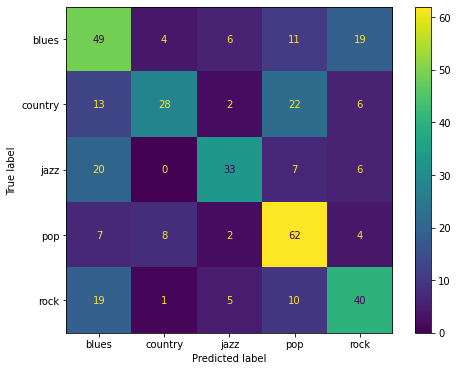

In [ ]:
cm = confusion_matrix(y_allFeatures_test, predictions, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['blues', 'country', 'jazz', 'pop', 'rock'])
disp.plot()
plt.show()


## Discussion

**What might the answer imply and why does it matter? How does it fit in with what other researchers have found? What are the perspectives for future research? Survey about the tools investigated for this assignment.**

The level of accuracy we attained implies the need for further research to be able to increase the accuracy of the predictions made. Some ideas for future research could include a more thorough analysis of the lyrical content of the songs in our dataset, as well as more characteristics on them such as rhythm. For this project we were able to use a variety of tools. Some of the tools we utilized were pandas for holding our data in a data frame and some visualization tools we used were seaborn and matplotlib. Finally we also implemented sklearn for separating the training and test data as well as some of their machine learning algorithms.



## Summary
**Most important findings.**

In this project we sought out a way to use classification to identify the genre of a song based on its associated features. We used Scikit-Learn's classification estimators to get these predictions. The degree of accuracy was not to our initial expectation, but it gave us good practice in trying to identify different ways of increasing our accuracy. One of our most important findings was figuring out which features should be included. We made three sets of predictors; first being the features associated with the topic of the songs, next being the features associated with the characteristics of the songs (such as danceability), and lastly we had both together. We found that the predictors with the highest accuracy was the last set which included both the topic and characteristics. Another important finding was that using songs after 2017 also increased our accuracy, this is most likely due to music changing so much in the years prior. Lastly a very important finding was which classification machine learning algorithm would yield the highest accuracy and we found that to be the Random Forest Classification. 